In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#set size plot
plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
#read file
M42 = fits.open('data/frame-u-006073-4-0063.fits')

In [4]:
M42.info()

Filename: data/frame-u-006073-4-0063.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


In [5]:
M42[0].header

SIMPLE  =                    T /                                                
BITPIX  =                  -32 / 32 bit floating point                          
NAXIS   =                    2                                                  
NAXIS1  =                 2048                                                  
NAXIS2  =                 1489                                                  
EXTEND  =                    T /Extensions may be present                       
BZERO   =              0.00000 /Set by MRD_SCALE                                
BSCALE  =              1.00000 /Set by MRD_SCALE                                
TAI     =        4649973257.37 / 1st row Number of seconds since Nov 17 1858    
RA      =            83.820000 / 1st row RA of telescope boresight (deg)        
DEC     =           -5.349071  / 1st row Dec of telescope boresight (degrees)   
SPA     =             180.000  / 1st row Cam col position angle wrt N (deg)     
IPA     =             137.18

In [8]:
#Get data
data = M42[0].data
print(f'Data type: {type(data)}, shape: {data.shape}')

Data type: <class 'numpy.ndarray'>, shape: (1489, 2048)


In [9]:
print(f'Min: {np.min(data)}')
print(f'Max: {np.max(data)}')
print(f'Mean: {np.mean(data)}')
print(f'Stdev: {np.std(data)}')

Min: -0.3447265625
Max: 552.0
Mean: 5.339874744415283
Stdev: 15.16415023803711


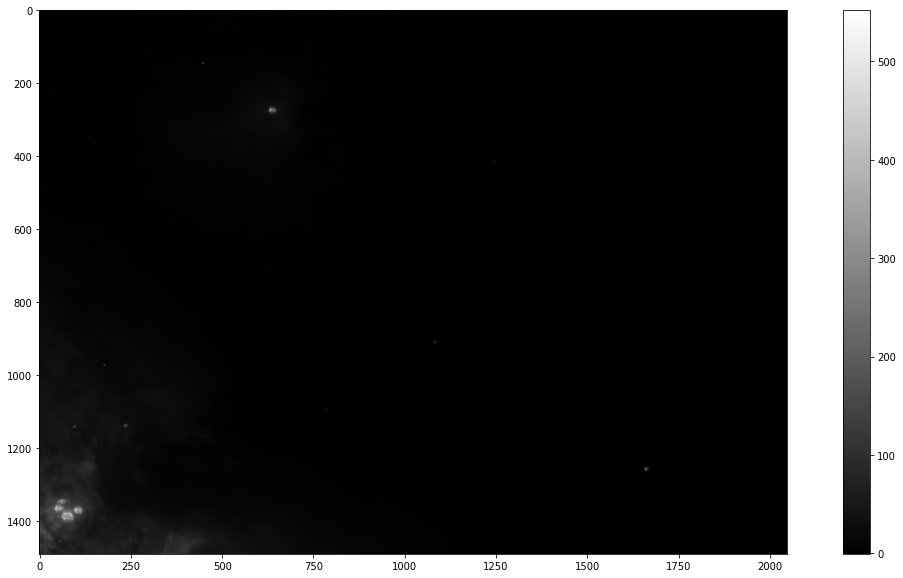

In [19]:
#show image im gray color
plt.imshow(data, cmap='gray')
plt.colorbar()

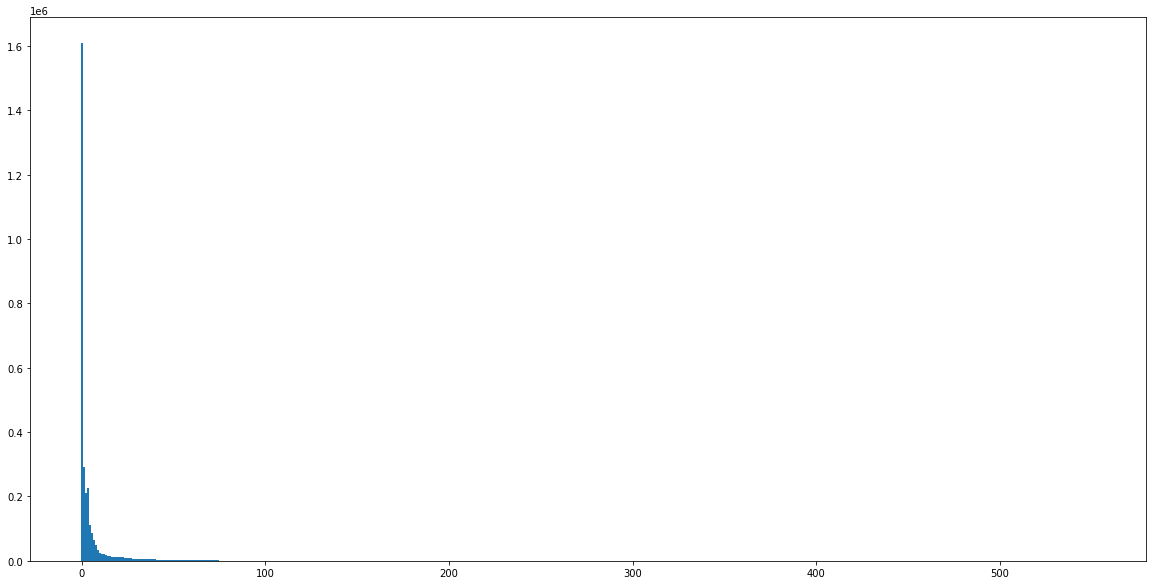

In [20]:
#plot histogram
histogram = plt.hist(data.flat, bins=500)